In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1) Load
sales = pd.read_csv("data/sales_cleaned.csv")
logs = pd.read_csv("data/logs.csv")

# 2) Parse types
sales["contract_end_date"] = pd.to_datetime(sales["contract_end_date"], errors="coerce")
logs["date"] = pd.to_datetime(logs["date"], errors="coerce")

sales["is_churned"] = pd.to_numeric(sales["is_churned"], errors="coerce").fillna(0).astype(int)
logs["logins"] = pd.to_numeric(logs["logins"], errors="coerce").fillna(0)

# drop rows with no date/customer_id
sales = sales.dropna(subset=["customer_id"]).copy()
logs = logs.dropna(subset=["customer_id", "date"]).copy()

# Ensure customer_id string-like for stable merges
sales["customer_id"] = sales["customer_id"].astype(str)
logs["customer_id"] = logs["customer_id"].astype(str)

In [3]:
# 3) Define churn reference date
as_of_date = logs["date"].max()

sales["churn_ref_date"] = np.where(
    sales["is_churned"].eq(1),
    sales["contract_end_date"],
    as_of_date
)
sales["churn_ref_date"] = pd.to_datetime(sales["churn_ref_date"], errors="coerce")

# 4) Align logs relative to churn date
sales_cols_to_merge = ["customer_id", "is_churned", "churn_ref_date"]
for c in ["company_size_bucket", "product_tier", "sales_segment", "industry", "is_eu", "region", "initial_onboarding_score"]:
    if c in sales.columns:
        sales_cols_to_merge.append(c)

log_aligned = logs.merge(sales[sales_cols_to_merge], on="customer_id", how="inner")
log_aligned["days_to_churn"] = (log_aligned["date"] - log_aligned["churn_ref_date"]).dt.days  # negative = before churn_ref

# 5) Handle known issue: corrupted EU September logs
FILTER_EU_SEPT = False
EU_SEPT_START = pd.Timestamp("2024-09-01")
EU_SEPT_END = pd.Timestamp("2024-09-30")

if FILTER_EU_SEPT and "is_eu" in log_aligned.columns:
    mask_eu_sept = (
        log_aligned["is_eu"].eq(1)
        & (log_aligned["date"] >= EU_SEPT_START)
        & (log_aligned["date"] <= EU_SEPT_END)
    )
    log_aligned = log_aligned.loc[~mask_eu_sept].copy()

In [4]:
log_aligned.head()

,Unnamed: 0,customer_id,date,logins,feature_events,session_minutes,is_churned,churn_ref_date,company_size_bucket,product_tier,sales_segment,industry,is_eu,region,initial_onboarding_score,days_to_churn
0,0,C100000,2024-01-01,5.0,0.0,32.23,0,2024-12-31,51-200,Growth,MidMarket,Healthcare,0,North America,7.0,-365
1,1,C100000,2024-01-02,1.0,1.0,18.08,0,2024-12-31,51-200,Growth,MidMarket,Healthcare,0,North America,7.0,-364
2,2,C100000,2024-01-03,3.0,1.0,9.10,0,2024-12-31,51-200,Growth,MidMarket,Healthcare,0,North America,7.0,-363
3,3,C100000,2024-01-04,3.0,1.0,37.60,0,2024-12-31,51-200,Growth,MidMarket,Healthcare,0,North America,7.0,-362
4,4,C100000,2024-01-05,5.0,2.0,25.20,0,2024-12-31,51-200,Growth,MidMarket,Healthcare,0,North America,7.0,-361


In [5]:
# 6) Define pre-churn windows (days_to_churn in [start, end))
WINDOWS = [
    ("logins_m90_m60", -90, -60),
    ("logins_m60_m30", -60, -30),
    ("logins_m30_0",   -30, 0),
]

def window_sum(df: pd.DataFrame, start_day: int, end_day: int, value_col: str = "logins") -> pd.Series:
    m = (df["days_to_churn"] >= start_day) & (df["days_to_churn"] < end_day)
    return df.loc[m].groupby("customer_id")[value_col].sum()

# Build customer-level feature table
features = pd.DataFrame({"customer_id": sales["customer_id"].unique()}).set_index("customer_id")

for name, start, end in WINDOWS:
    features[name] = window_sum(log_aligned, start, end, "logins")

features = features.fillna(0).reset_index()

# 7) Create drop-off metrics
EPS = 1e-9
features["pct_drop_last_30_vs_prev_30"] = (
    (features["logins_m60_m30"] - features["logins_m30_0"]) / (features["logins_m60_m30"] + EPS)
)
features["delta_last_30_vs_prev_30"] = features["logins_m30_0"] - features["logins_m60_m30"]

# Flag “drop-off” customers (customize thresholds)
features["drop_gt_30pct"] = (features["logins_m60_m30"] > 0) & (features["pct_drop_last_30_vs_prev_30"] > 0.3)

# 8) Build master dataset
master = sales.merge(features, on="customer_id", how="left")
for col in ["logins_m90_m60", "logins_m60_m30", "logins_m30_0", "pct_drop_last_30_vs_prev_30", "delta_last_30_vs_prev_30"]:
    master[col] = pd.to_numeric(master[col], errors="coerce").fillna(0)


In [6]:
master.head()

,Unnamed: 0,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,...,discount_pct,initial_onboarding_score,is_churned,churn_ref_date,logins_m90_m60,logins_m60_m30,logins_m30_0,pct_drop_last_30_vs_prev_30,delta_last_30_vs_prev_30,drop_gt_30pct
0,0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,...,0.03,7.0,0,2024-12-31,114.0,126.0,114.0,0.095238,-12.0,False
1,1,C100001,Company_1,UK,Europe,1,Wholesale,1-10,1799.72,Starter,...,0.15,4.9,0,2024-12-31,26.0,29.0,28.0,0.034483,-1.0,False
2,2,C100002,Company_2,US,North America,0,Manufacturing,1-10,1770.83,Starter,...,0.37,4.8,1,2024-05-13,22.0,31.0,30.0,0.032258,-1.0,False
3,3,C100003,Company_3,France,Europe,1,Missing,1-10,1790.30,Starter,...,0.10,8.0,0,2024-12-31,19.0,32.0,26.0,0.187500,-6.0,False
4,4,C100004,Company_4,Netherlands,Europe,1,Professional Services,1-10,1552.00,Starter,...,0.11,3.8,1,2024-03-10,13.0,25.0,19.0,0.240000,-6.0,False


In [8]:
master[master["is_eu"] == 1]["churn_ref_date"].isna().sum()

np.int64(0)


MASTER DATASET OVERVIEW
Customers: 3000
Churn rate: 0.12133333333333333

MEAN NUMBRE OF LOGINS (CHURNED vs RETAINED)
            logins_m90_m60  logins_m60_m30  logins_m30_0
is_churned                                              
0                96.843703       90.414264     83.931335
1                28.607143       35.835165     42.159341

SHARE OF CUSTOMERS WITH > 30% DROP (CHURNED vs RETAINED)
is_churned
0    0.095220
1    0.016484
Name: drop_gt_30pct, dtype: float64


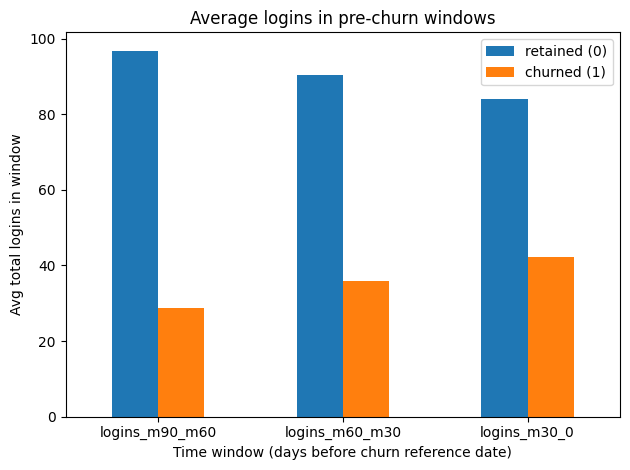

'\nHow to interpret key outputs:\n\n- mean_by_churn:\n    If churned customers show lower usage overall, it suggests weak activation/adoption.\n    If churned customers show a sharp decline near churn while retained stays stable,\n    that supports an engagement drop-off narrative.\n\n- pct_drop_last_30_vs_prev_30:\n    >0 means last 30 days usage is LOWER than previous 30 days\n    ~0 means stable\n    <0 means usage increased in last 30 days (rare but possible)\n\nTip: The pct drop can explode if logins_m60_m30 is 0.\nWe guarded division by EPS, and also created drop flags that require logins_m60_m30 > 0.\n'

In [ ]:
# Core summaries
print("\n==============================")
print("MASTER DATASET OVERVIEW")
print("==============================")
print("Customers:", master.shape[0])
print("Churn rate:", master["is_churned"].mean())

print("\n==============================")
print("MEAN NUMBRE OF LOGINS (CHURNED vs RETAINED)")
print("==============================")
mean_by_churn = master.groupby("is_churned")[["logins_m90_m60", "logins_m60_m30", "logins_m30_0"]].mean()
print(mean_by_churn)

print("\n==============================")
print("SHARE OF CUSTOMERS WITH > 30% DROP (CHURNED vs RETAINED)")
print("==============================")
share_drop50 = master.merge(features[["customer_id", "drop_gt_30pct"]], on="customer_id", how="left")
print(master.groupby("is_churned")["drop_gt_30pct"].mean())

# Plot: Avg logins by window (churned vs retained)
plot_df = mean_by_churn.copy()
ax = plot_df.T.plot(kind="bar")
ax.set_title("Average logins in pre-churn windows")
ax.set_xlabel("Time window (days before churn reference date)")
ax.set_ylabel("Avg total logins in window")
ax.legend(["retained (0)", "churned (1)"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()